In [1]:
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np
import csv

import csv 
from PIL import Image
import io
import pandas as pd 
import torch
from torchvision import datasets, transforms, models, utils
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torch.utils.data import ConcatDataset, DataLoader
import torchvision.transforms as transforms
from datetime import datetime
from torchvision.transforms.functional import to_pil_image
import torch.optim as optim
import torch.nn as nn
import random
import pandas as pd 
from skimage import io, transform, img_as_ubyte
import numpy as np
import matplotlib.pyplot as plt


RuntimeError: operator torchvision::nms does not exist

In [ ]:




train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
m,n = train.shape


img = []
img_size = 96
for i in range(m):
    image = train['Var31'][i]
    splitting = np.fromstring(image, sep=' ').astype(np.float32).reshape(96, 96) / 255.0
    img.append(splitting)
img = np.array(img)

X_train = img
train.drop('Var31', axis = 1, inplace = True)
y_train = []

for i in range(len(train)):
    y = train.iloc[i,:].values
    y_train.append(y)
    
    
y_train= np.array(y_train, dtype = 'float')


####TEST
img_test = []
img_size = 96
m,n = test.shape
for i in range(m):
    image = test['Var31'][i]

    splitting = np.fromstring(image, sep=' ').astype(np.float32).reshape(96, 96) / 255.0
    img_test.append(splitting)

img_test = np.array(img_test)

X_test = img_test
test.drop('Var31', axis = 1, inplace = True)

y_test = []

for i in range(len(test)):
    y = test.iloc[i,:].values
    y_test.append(y)
    
    
y_test= np.array(y_test, dtype = 'float')


class RandomCrop(object):
    """Crop randomly the image in a sample and adjust keypoints accordingly."""

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        x, y = sample['image'], sample['keypoints']
        h, w = x.shape[1:3]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)
        x = x[:,top: top + new_h, left: left + new_w]

        
        y = y.reshape(-1,1,2) - [left, top]
        
        y = y.flatten()
        return {'image': x, 'keypoints': y}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        x, y = sample['image'], sample['keypoints']
        h, w = x.shape[1:3]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        x = transform.resize(x, (1,new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        y = y.reshape(-1,1,2)* [new_w / w, new_h / h]
        y = y.flatten()

        return {'image': x, 'keypoints': y}

class RandomHorizontalFlip(object):

    def __init__(self, probability):
        self.probability = probability

    def __call__(self, sample):
        x_, y_ = sample['image'], sample['keypoints']
        if random.random() < self.probability:

            x = x_.copy()
            y = y_.copy()
            h, w = x.shape[1:3]
            x = x[:,:,::-1].copy()
            y = y.reshape(-1,2)
            y[:,::2] = w - y[:,::2]
            y = y.flatten()
            return {'image': x, 'keypoints': y}
        else:
            return {'image': x_, 'keypoints': y_}
class AdjustBrightness(object):

    def __init__(self, max_bright):
        self.max_bright = max_bright

    def __call__(self, sample):
        brightness = np.random.uniform(max(1-self.max_bright,0.1), self.max_bright)
        x, y = sample['image'], sample['keypoints']
        X_b = np.clip(x*brightness, x.min(), x.max())
        return {'image': X_b, 'keypoints': y}
        
class Normalise(object):

    def __call__(self, sample):
        
        x, y = sample['image'], sample['keypoints']
        h, w = x.shape[1:3]
        x_copy = np.copy(x)
        y_copy = np.copy(y)
        x_copy = x_copy/255.0
        y_copy = y_copy.reshape(-1,2)
        y_copy[:, 0] = y_copy[:, 0] / w
        y_copy[:, 1] = y_copy[:, 1] / h
        y_copy = y.flatten()
        return {'image': x_copy, 'keypoints': y_copy}  
        
class RandomShift(object):
    """Randomly shift the image and keypoints in a sample."""

    def __init__(self, shift_range=10):
        """
        Args:
            shift_range (int, tuple of int): Maximum distance to shift the image in the X and Y directions.
                If int, the same shift range is used for both directions.
                If tuple, separate shift ranges are used for the X (horizontal) and Y (vertical) directions.
        """
        self.shift_range = shift_range if isinstance(shift_range, tuple) else (shift_range, shift_range)

    def __call__(self, sample):
        x, y = sample['image'], sample['keypoints']
        h, w = x.shape[1:3]
        max_dx, max_dy = self.shift_range
        dx = np.random.randint(-max_dx, max_dx + 1)
        dy = np.random.randint(-max_dy, max_dy + 1)

        # Shift image
        x_shifted = np.roll(x, shift=(dy, dx), axis=(1, 2))
        
        if dy > 0:
            x_shifted[:, :dy, :] = 0
        elif dy < 0:
            x_shifted[:, dy:, :] = 0
        if dx > 0:
            x_shifted[:, :, :dx] = 0
        elif dx < 0:
            x_shifted[:, :, dx:] = 0

        # Shift keypoints
        y = y.reshape(-1, 2)  
        y_shifted = y + [dx, dy]
        y_shifted = y_shifted.flatten()

        return {'image': x_shifted, 'keypoints': y_shifted}
        
    
class RandomNoise(object):
    """Randomly rotate the image and keypoints in a sample."""

    def __call__(self, sample):
        x, y = sample['image'], sample['keypoints']
        h, w = x.shape[1], x.shape[2]
        if x.shape !=(h,w, 1):
            x = x.reshape(h, w, 1)
        x = x.astype(np.float32)
        x = cv2.add(x, 0.008*np.random.randn(96,96,1).astype(np.float32))
        x = x.reshape(-1, h, w)
        return {'image': x, 'keypoints': y}


        
class Data(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data.reshape(-1, 1, 96, 96)
        self.y_data = y_data
        self.transform = transform
    
    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, index):
        x = self.x_data[index]
        y = self.y_data[index]
        sample = {'image': x, 'keypoints': y}
        if self.transform:
            sample = self.transform(sample)

        return sample['image'], sample['keypoints']


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        x, y = sample['image'], sample['keypoints']
        return {'image': torch.from_numpy(x).float(), 'keypoints': torch.from_numpy(y).float()}

def rotateImage(image, angle):
    row,col, _ = image.shape
    center=tuple(np.array([row,col])/2)
    rot_mat = cv2.getRotationMatrix2D(center,angle,1.0)
    new_image = cv2.warpAffine(image, rot_mat, (col,row))
    return new_image
class RandomRotate(object):
    """Randomly rotate the image and keypoints in a sample."""

    def __init__(self, max_angle):
        self.max_angle = max_angle

    def __call__(self, sample):
        x, y = sample['image'], sample['keypoints']
        h, w = x.shape[1:3]
        angle = np.random.uniform(-self.max_angle, self.max_angle)
        

        x_rot = rotateImage(x.T, angle)
        x_rot = x_rot.T.reshape(-1, h, w)
        

        y = y.reshape(-1, 2)
        y = y - [w/2, h/2]
        y_rot = y @ np.array([[np.cos(np.radians(-angle)), -np.sin(np.radians(-angle))], [np.sin(np.radians(-angle)), np.cos(np.radians(-angle))]])
        y_rot = y_rot + [w/2, h/2]
        y_rot = y_rot.flatten()
        return {'image': x_rot, 'keypoints': y_rot}

data_transform1 = transforms.Compose([
    RandomHorizontalFlip(0.5),
    RandomNoise(),
    ToTensor()
])

data_transform2= transforms.Compose([
    RandomCrop(91),
    RandomRotate(5),
    RandomShift(5),
    Rescale(96),
    RandomNoise(),
    ToTensor()
])

data_transform3= transforms.Compose([
    RandomShift(10),
    RandomNoise(),
    ToTensor()
])

data_transform4= transforms.Compose([
    AdjustBrightness(0.7),
    RandomNoise(),
    ToTensor()
])

data_transform5 = transforms.Compose([
    RandomRotate(15),
    RandomNoise(),
    ToTensor()
])

data_transform5_5 = transforms.Compose([
    RandomShift(5),
    RandomNoise(),
    RandomRotate(5),
    AdjustBrightness(0.7),
    ToTensor()
])

data_transform5_5_5 = transforms.Compose([
    RandomNoise(),
    ToTensor()
])

data_transform6 = transforms.Compose([
    ToTensor()
])



torch.Size([100, 1, 96, 96])


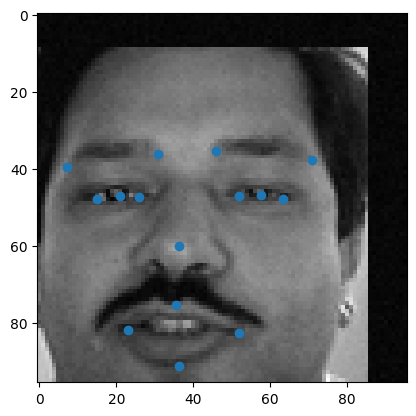

torch.Size([100, 1, 96, 96])


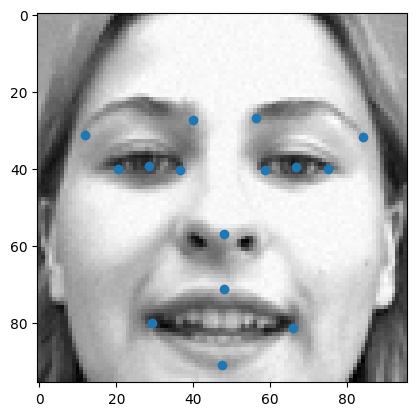

torch.Size([100, 1, 96, 96])


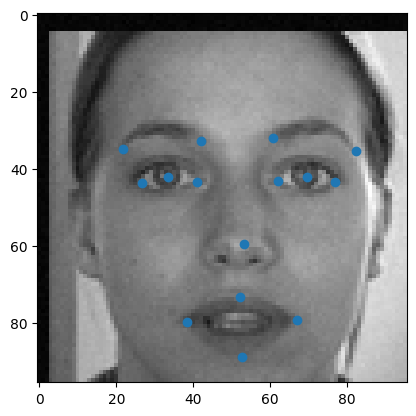

torch.Size([100, 1, 96, 96])


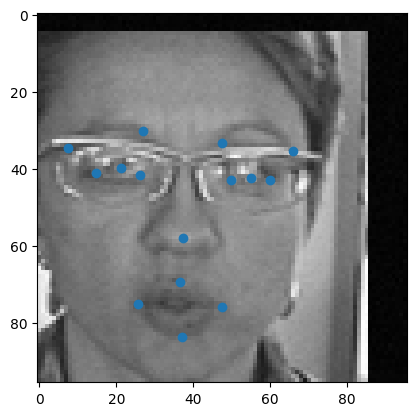

torch.Size([100, 1, 96, 96])


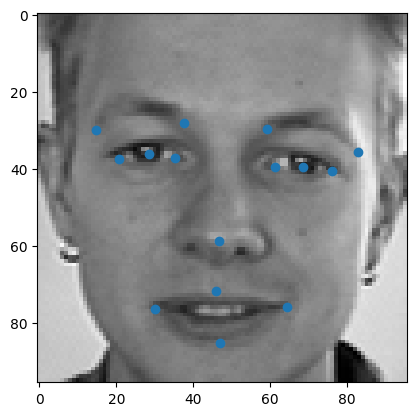

torch.Size([100, 1, 96, 96])


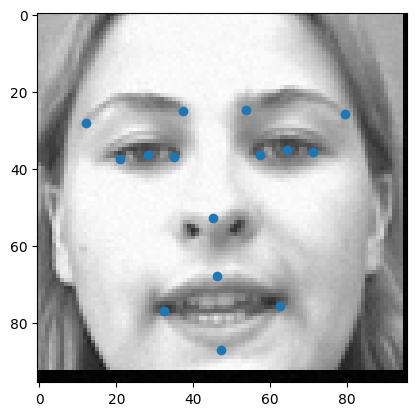

torch.Size([100, 1, 96, 96])


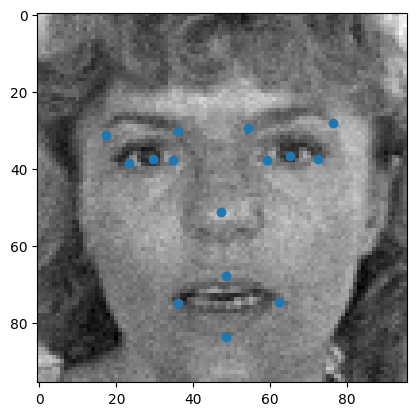

torch.Size([100, 1, 96, 96])


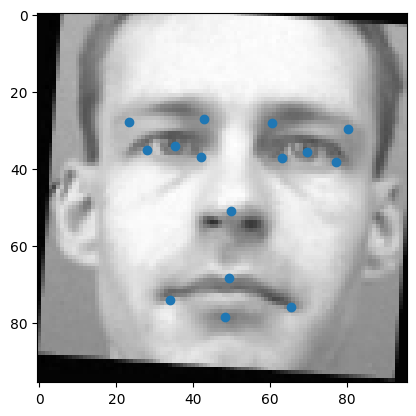

In [3]:
learning_rate = 0.01
num_epochs = 10

original_dataset = Data(X_train, y_train, transform=data_transform1)
augmented_dataset1 = Data(X_train, y_train, transform=data_transform2)
augmented_dataset2 = Data(X_train, y_train, transform=data_transform3)
augmented_dataset3 = Data(X_train, y_train, transform=data_transform4)
augmented_dataset4 = Data(X_train, y_train, transform=data_transform5)
augmented_dataset5 = Data(X_train, y_train, transform=data_transform6)
augmented_dataset5_5 = Data(X_train, y_train, transform=data_transform5_5)
augmented_dataset5_5_5 = Data(X_train, y_train, transform=data_transform5_5_5)
# Combine datasets
combined_dataset = ConcatDataset([original_dataset, augmented_dataset1, augmented_dataset2,
                                  augmented_dataset3, augmented_dataset4,augmented_dataset5_5, augmented_dataset5,augmented_dataset5_5_5])

train_loader = DataLoader(combined_dataset, batch_size=100,
                        shuffle=True, num_workers=0)

test_loader = DataLoader(Data(X_test,y_test, transform=data_transform6),
                        shuffle=False, num_workers=0)


for i, (inputs, labels) in enumerate(train_loader):
    print(inputs.shape)
    plt.imshow(inputs[0].numpy().squeeze(), cmap='gray')
    labels = labels.reshape(labels.shape[0],15,2)
    plt.scatter(labels[0][:,0], labels[0][:,1])
    plt.show()



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 7, 1, padding='valid')  # Output: 14x14
        self.conv1_1 = nn.Conv2d(64, 64, 7, 1, padding='same')  # Output: 14x14
        self.conv2 = nn.Conv2d(64, 128, 7, 1, padding='same')  # Output: 5x5
        self.conv2_2 = nn.Conv2d(128, 128, 7, 1, padding='same')
        self.conv3 = nn.Conv2d(128, 256, 1, 1, padding='same')  # Output: 3x3

        self.pool = nn.MaxPool2d(2, 2)  # Output: 7x7, 2x2
        self.batchnorm1 = nn.BatchNorm2d(num_features=64)
        self.batchnorm2 = nn.BatchNorm2d(num_features=128)
        self.batchnorm3 = nn.BatchNorm2d(num_features=256)
        self.fc1 = nn.Linear(256 * 1 * 1, 128)  # Assuming the spatial size is 1x1 after pooling
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 30)
        self.drop = nn.Dropout(0.2)
        self.initialize_weights()

    def initialize_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='leaky_relu')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

    def forward(self, x):  # Defines the forward pass
        # First block with skip connection
        identity = x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        
 
        x = self.conv1_1(x)
        x+= identity
        x = self.batchnorm1(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.pool(x)
        

        identity = x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x+= identity
        x = self.conv2_2(x)
        x = self.batchnorm2(x)
        x = F.leaky_relu(x, negative_slope=0.01)

        x = self.pool(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = self.drop(x)
        identity = x = self.fc1(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.drop(x)
        x+= identity
        x = self.fc2(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.drop(x)
        x = self.fc3(x)

        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net()
model.to(device)


Net(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=valid)
  (conv1_1): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (conv2_2): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=30, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)

In [8]:

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)


In [1468]:
loss_values = []
for epoch in range(num_epochs):
    losses = []
    running_loss = 0.0

    for batch_idx, (img, keypoints) in enumerate(train_loader):
        # If GPU is active, alter the data accordingly
        data = img.to(device=device).float()
        targets = keypoints.to(device=device).float()

        # forward
        outputs = model(data)

        loss = criterion(outputs, targets)

        losses.append(loss.item())
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent
        optimizer.step()


    loss_values.append(sum(losses)/len(losses))
    print(f"Loss at epoch {epoch} is {sum(losses)/len(losses):.5f}")
torch.cuda.empty_cache()

Loss at epoch 0 is 1174.83393
Loss at epoch 1 is 306.22548
Loss at epoch 2 is 190.72673
Loss at epoch 3 is 161.79915
Loss at epoch 4 is 134.31849
Loss at epoch 5 is 135.63679
Loss at epoch 6 is 124.99372
Loss at epoch 7 is 132.43536
Loss at epoch 8 is 120.69414
Loss at epoch 9 is 125.32100


Text(0, 0.5, 'MSE Loss')

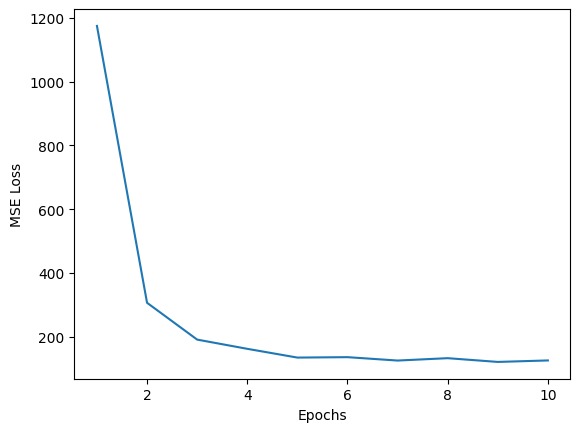

In [1469]:
plt.plot(list(range(1,len(loss_values)+1)), loss_values)
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')

In [1470]:
# del model
# del outputs
del keypoints
del img

In [1474]:
torch.save(model.state_dict(), '2-3_FKD.pth')

In [9]:
model.load_state_dict(torch.load('./2-3_FKD.pth'), strict = False)

<All keys matched successfully>

MSE: [9.908388330539067, 15.841276931762696, 36.28285048802694, 28.68017142613729, 13.715884526570639, 27.85395243962606, 67.29310363133749, 18.1695591767629, 9.99998544851939, 41.6235276222229, 41.09006854693095, 25.536105497678122, 26.864583222071328, 24.360264572501183, 52.8868096669515, 4.456118647257487, 47.14146712621053, 30.902245712280273, 7.830040674408277, 7.2262359698613485, 15.474581050872803, 14.154028948148092, 42.82404421170553, 49.01139860153198, 20.320683932304384]
Mean MSE: 4.456118647257487


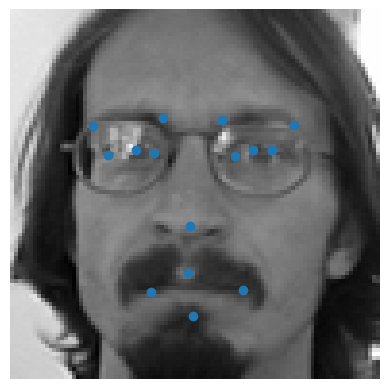

In [11]:
MSE = []
images = []
est_key = []
for i, (img, key) in enumerate(test_loader):
    with torch.no_grad():
        images.append(img.detach().numpy())
        img = img.to(device)
        model.eval()
        output = model(img)
        output = output.to('cpu')
        output = output.detach().numpy() 
        output = output.reshape(-1,2)
        est_key.append(output)
        key = key.detach().numpy()
        key = key.reshape(-1,2)

        total = 0   
        for j in range(len(output)):
            mse = output[j] - key[j]
            mse = np.sum(mse**2)
            total += mse
        mse = total/len(output)
        MSE.append(mse)

sorted_mse = np.argsort(MSE)



best_image = images[sorted_mse[0]].squeeze()
best_key = est_key[sorted_mse[0]].squeeze().reshape(15,2)
plt.imshow(best_image,cmap = 'gray')
plt.scatter(best_key[:,0],best_key[:,1])
plt.axis('off')
print(f'MSE: {MSE}')
print(f'Lowest MSE: {MSE[sorted_mse[0]]}')